# Running statistical tests on RTR data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%matplotlib inline

In [2]:
rtr_data = pd.read_csv('rtr_clean.csv')

In [3]:
rtr_data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
rtr_data.head()

,age,body_type,bust_size,category,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,review_datetime,band_size,cup_size,review_text_word_count,review_summary_word_count
0,28.0,hourglass,34d,romper,fit,68.0,2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137.0,2016-04-20,34.0,d,39,3
1,36.0,straight & narrow,34b,gown,fit,66.0,153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132.0,2013-06-18,34.0,b,41,4
2,116.0,NaN,NaN,sheath,fit,64.0,1063761,10.0,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,NaN,2015-12-14,NaN,NaN,39,17
3,34.0,pear,34c,dress,fit,65.0,126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135.0,2014-02-12,34.0,c,83,8
4,27.0,athletic,34b,gown,fit,69.0,616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145.0,2016-09-26,34.0,b,111,7


## Sizes from the RentTheRunway site

In [58]:
band_sizes = list(range(28, 50, 2))
cup_sizes = ['aa', 'a', 'b', 'c', 'd', 'dd', 'ddd/e', 'f', 'g', 'h', 'i', 'j']
rtr_bust_sizes = [str(band)+cup for band in band_sizes for cup in cup_sizes]
rtr_jean_sizes = list(range(24, 41))
rtr_dress_sizes = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, '24+']
rtr_body_types = ['apple', 'athletic', 'full bust', 'hourglass', 'pear', 'petite', 'straight & narrow']

In [32]:
rtr_body_types = ['apple', 'athletic', 'full bust', 'hourglass', 'pear', 'petite', 'straight & narrow']
rtr_data.body_type.unique()

array(['hourglass', 'straight & narrow', nan, 'pear', 'athletic',
       'full bust', 'petite', 'apple'], dtype=object)

In [6]:
rtr_data['size'].unique()

array([14, 12,  4,  8, 21,  1, 20,  2, 17, 16, 28, 36, 35, 24, 15,  5, 51,
       32, 23, 48, 45,  9, 13, 34, 39,  7, 25, 58, 26, 57, 29, 11,  0, 40,
        3, 33, 27, 43, 42, 19, 44, 54, 38, 10, 49, 52, 46,  6, 37, 22, 56,
       50, 41, 30, 55, 18], dtype=int64)

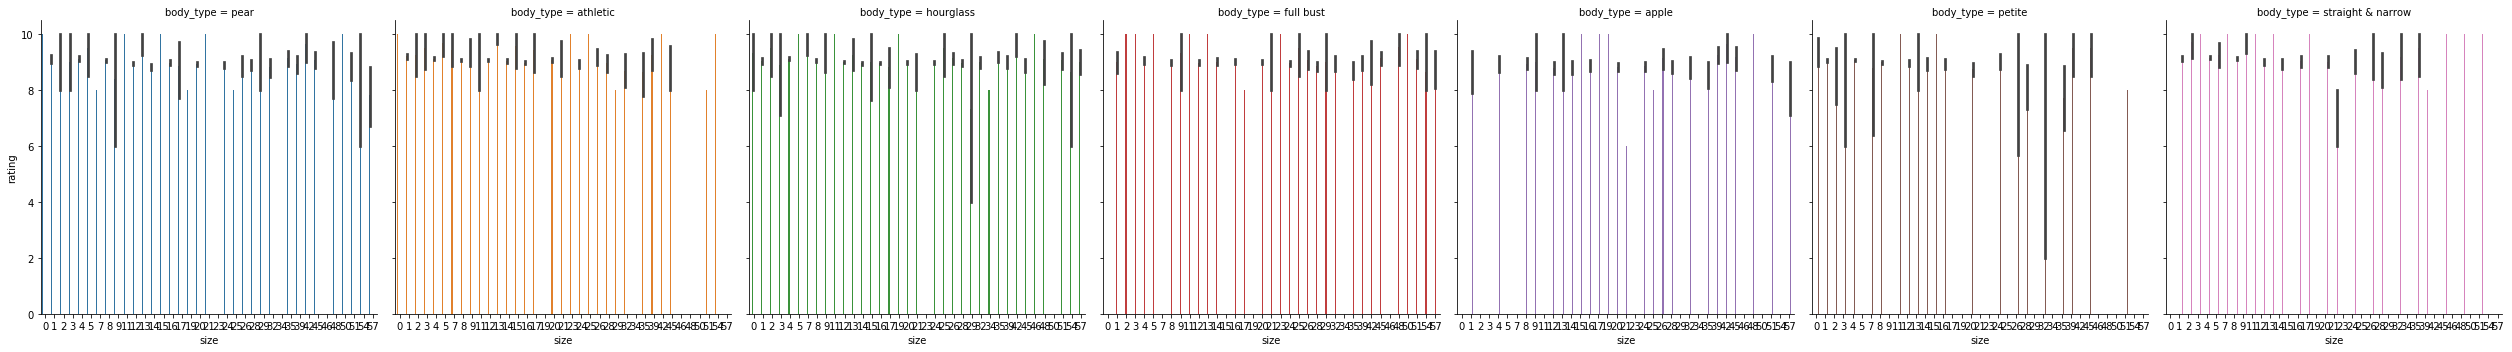

In [7]:
sns.catplot(x='size', y='rating', data=rtr_data.loc[rtr_data.category=='dress'], hue='body_type', col='body_type', kind='bar', linewidth=2.5)
plt.show()

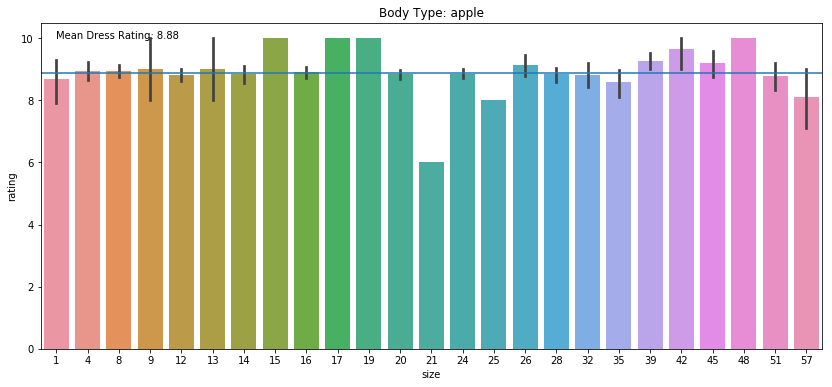

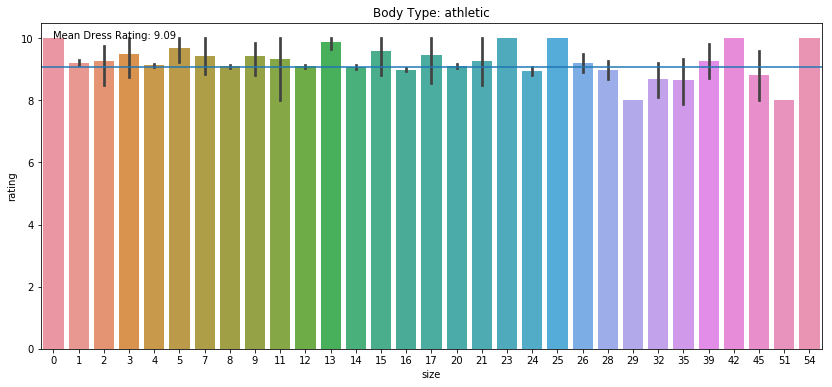

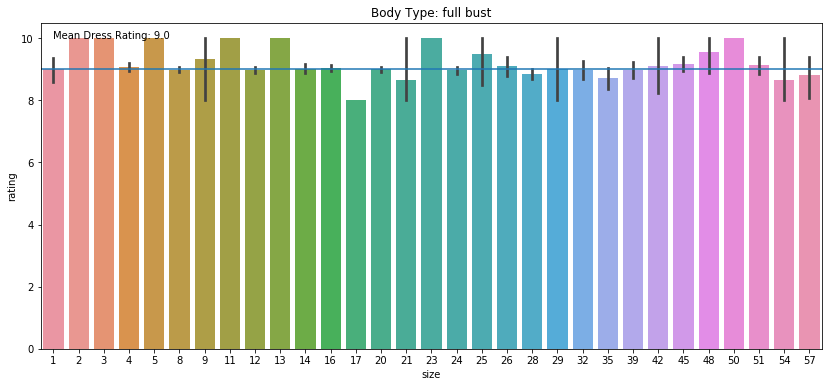

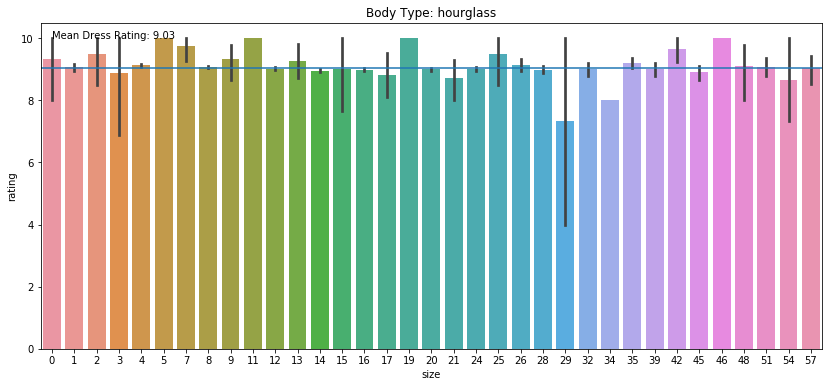

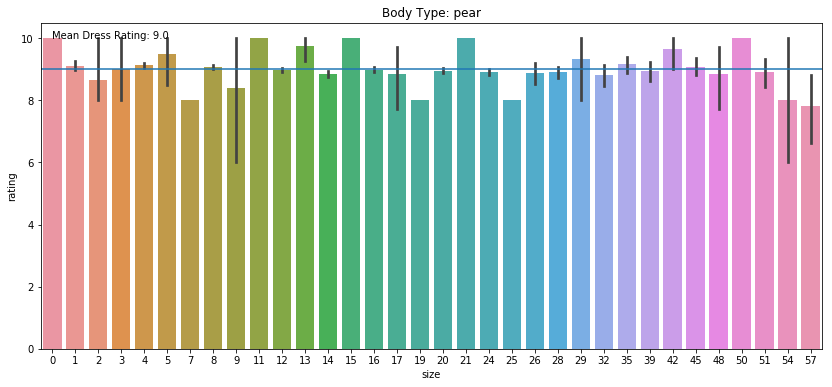

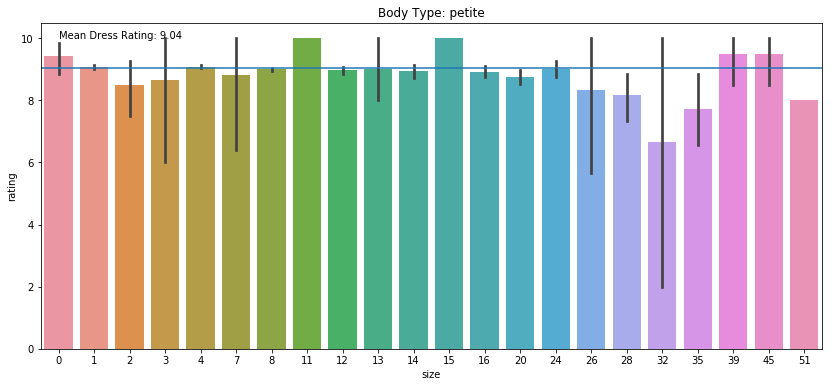

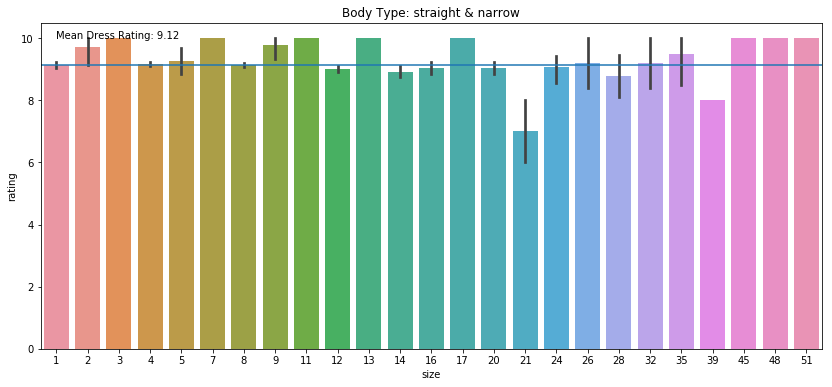

In [38]:
for bodytype in rtr_body_types:
    plt.figure(figsize=(14, 6))
    sns.barplot(x='size', y='rating', data=rtr_data.loc[(rtr_data.body_type==bodytype)&(rtr_data.category=='dress')])
    plt.title('Body Type: '+bodytype)
    mean = rtr_data.loc[(rtr_data.body_type==bodytype)&(rtr_data.category=='dress')].rating.mean()
    plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (0,10))
    plt.axhline(y=mean)
    plt.show()

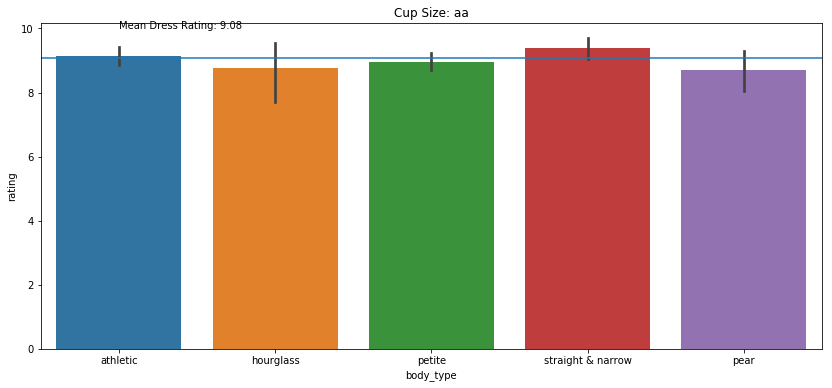

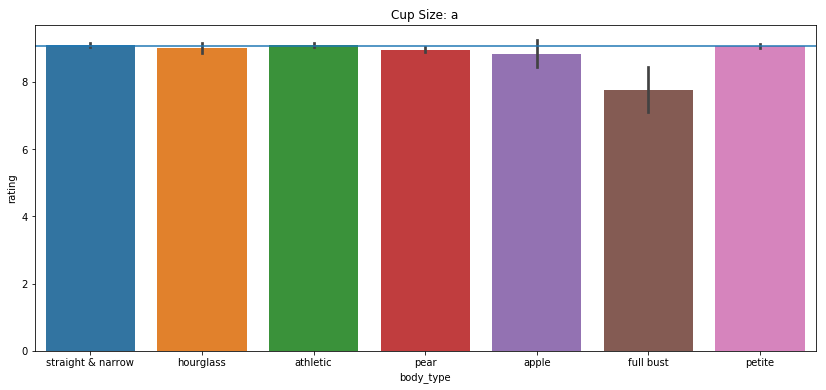

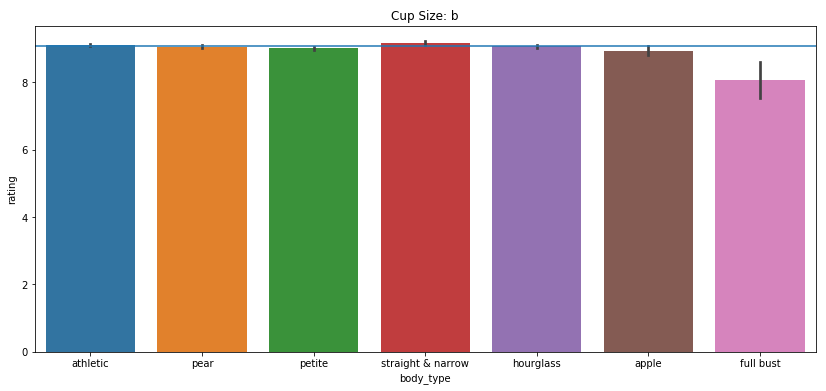

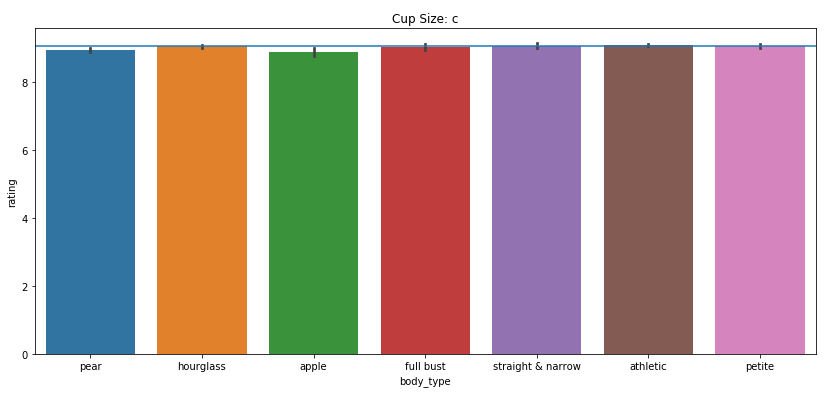

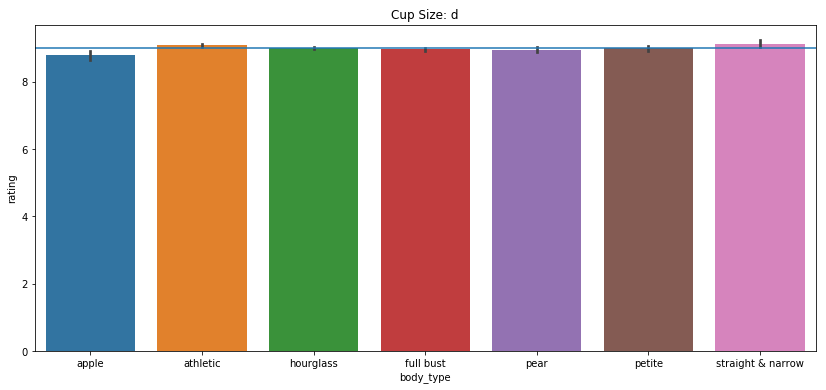

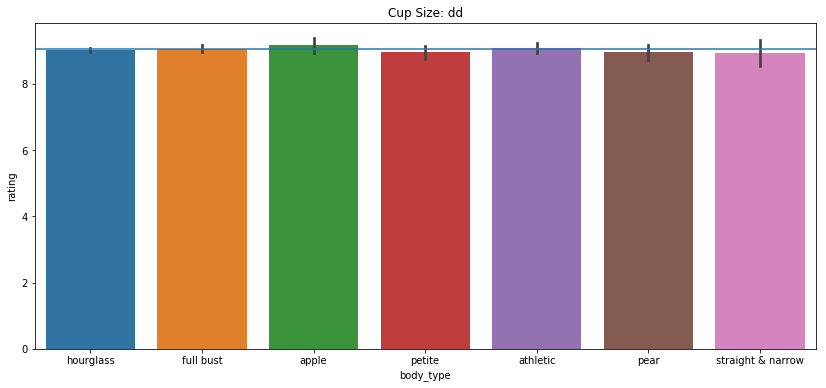

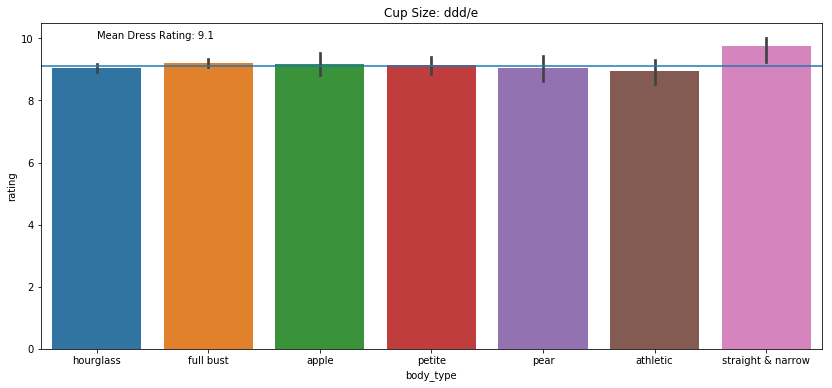

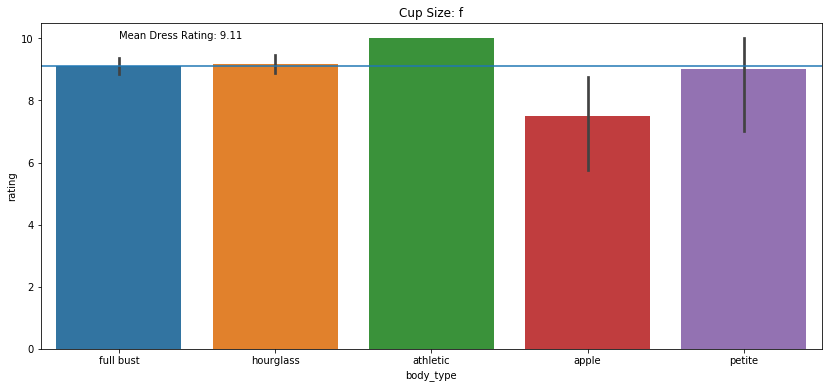

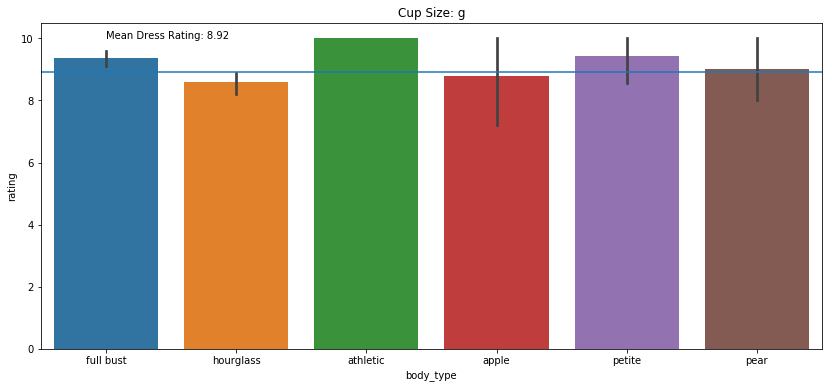

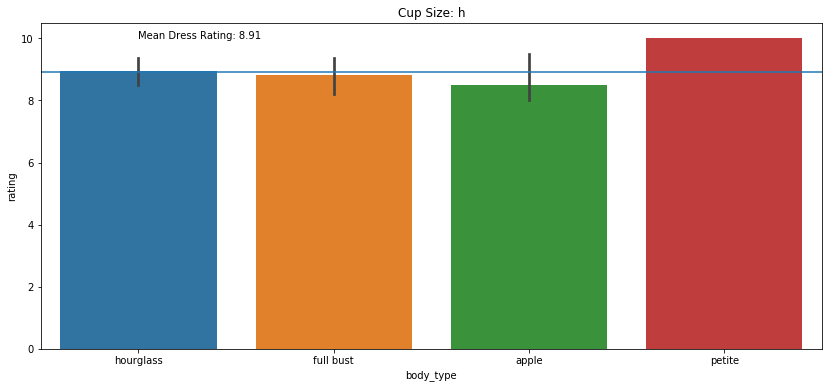

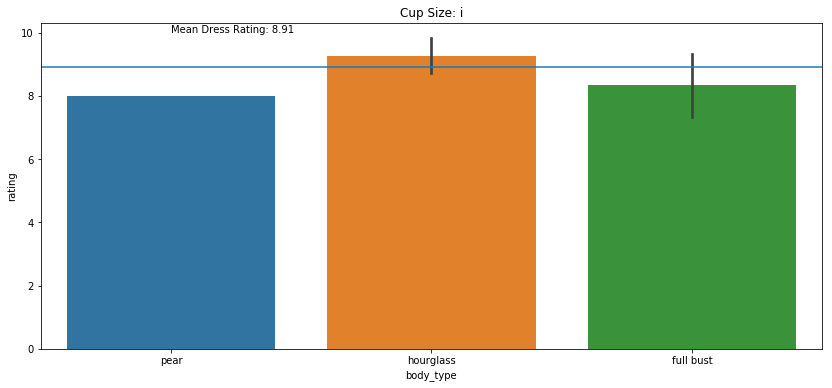

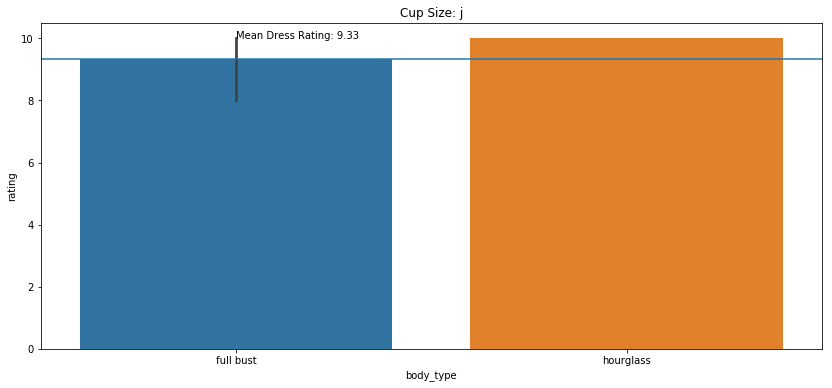

In [42]:
for cup in cup_sizes:
    plt.figure(figsize=(14, 6))
    sns.barplot(x='body_type', y='rating', data=rtr_data.loc[(rtr_data.cup_size==cup)&(rtr_data.category=='dress')])
    plt.title('Cup Size: '+cup)
    mean = rtr_data.loc[(rtr_data.cup_size==cup)&(rtr_data.category=='dress')].rating.mean()
    plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (0,10))
    plt.axhline(y=mean)
    plt.show()

So if the user self-described as _full bust_ and had a cup size smaller than a _b_, they seem more likely to rate the dress lower than average. 
In the other direction, if the user self-describes as _straight and narrow_ with a cup size of _ddd_, they seem more likely to rate the dress higher than average.

Next I want to know:
#### Did user's with different body types buy the same dresses? If so, how did ratings change?

### Did a user's body change over time?

In [57]:
rtr_users = rtr_data.groupby('user_id').count()

changed_users = []
for user in list(rtr_users.loc[rtr_users.review_date>1].index.values):
    total = len(rtr_data.loc[rtr_data.user_id==user])
    same = rtr_data.loc[rtr_data.user_id==user].duplicated(['bust_size', 'size', 'height'], keep=False).sum()
    if total-same>0:
        changed_users.append((user, total-same))

len(changed_users)

22986

***
## How many of each self-described body type are there?

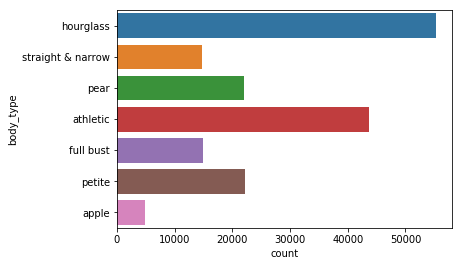

In [20]:
sns.countplot(data=rtr_data, y='body_type')
plt.show()

Looks like a lot of users self-describe as hourglass. 
We don't have waist or hip measurements in this data, but we do have ```band_size```, ```cup```, and ```weight```... maybe we can see if there is a relationship between these (again self-describd) variables and the ```body_type```.

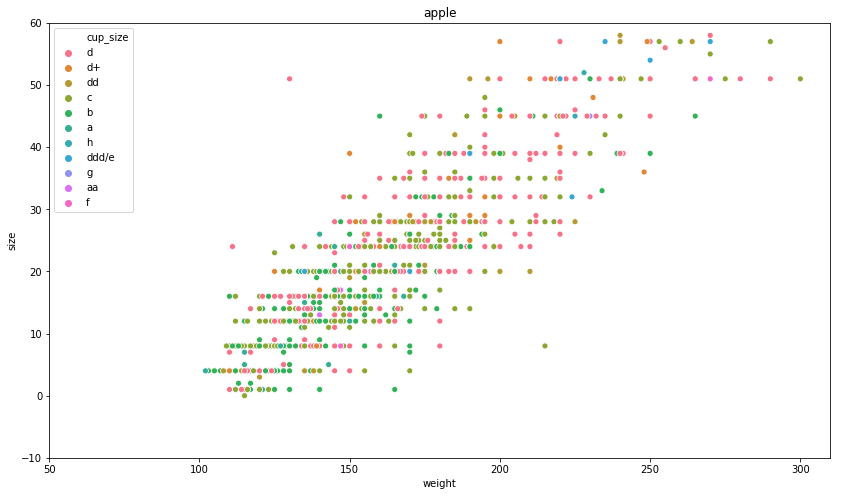

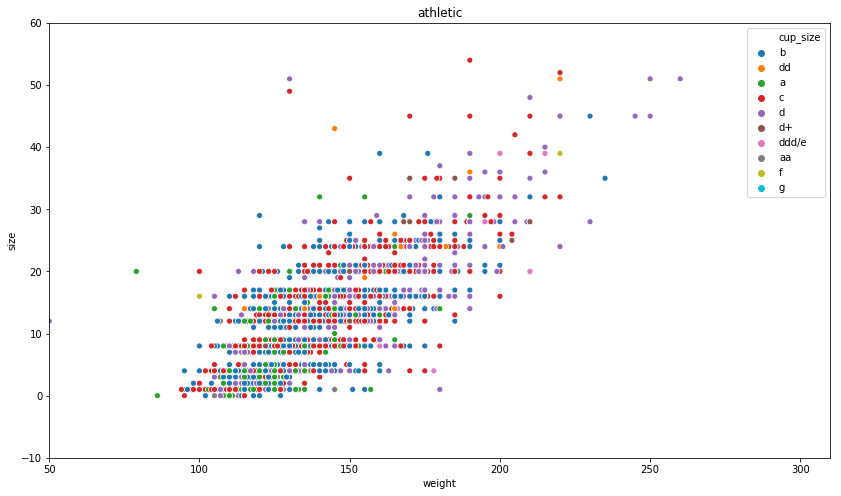

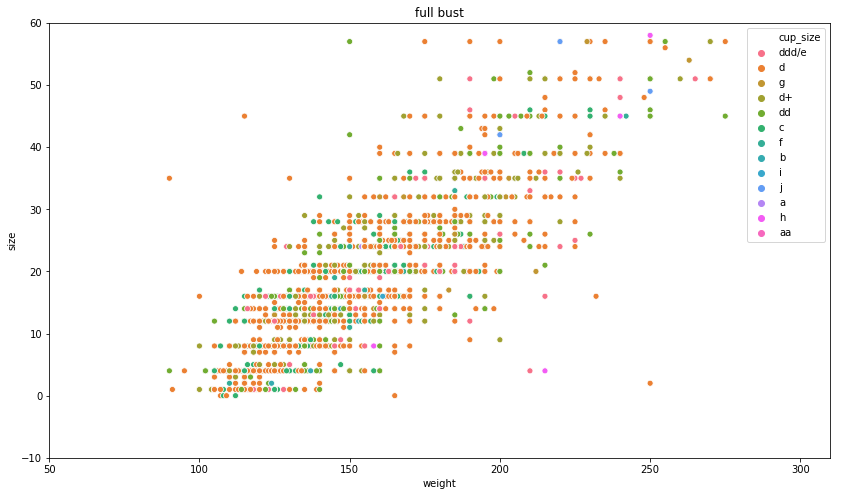

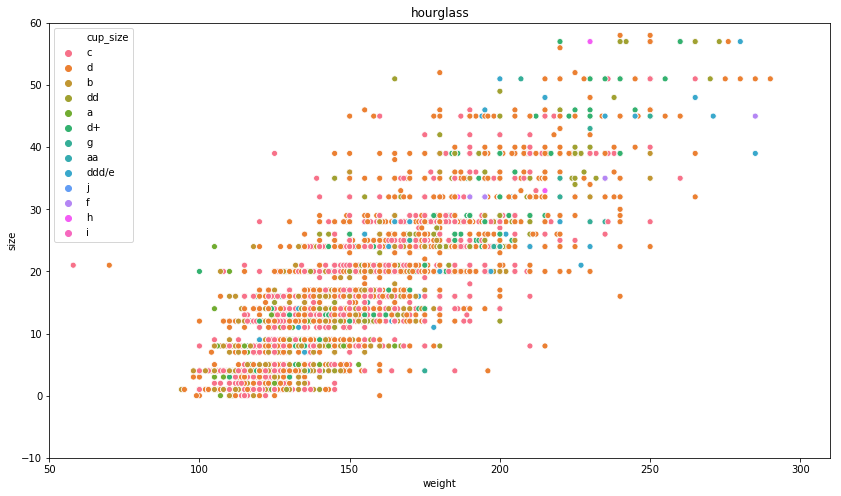

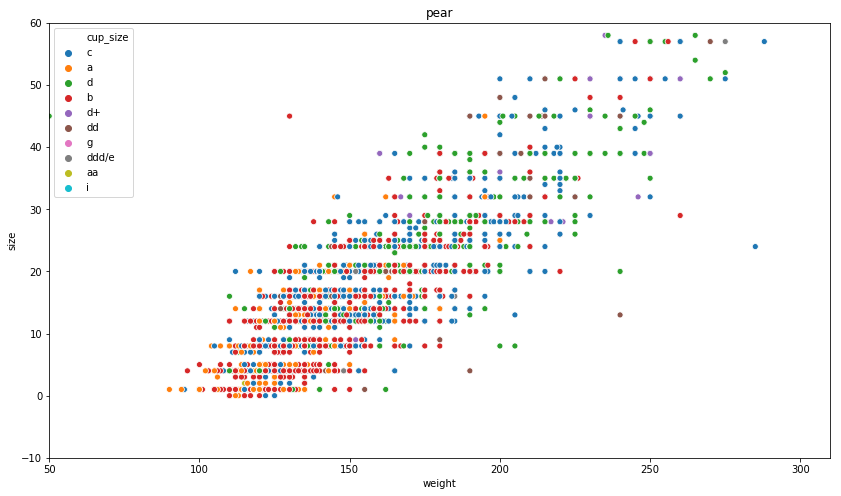

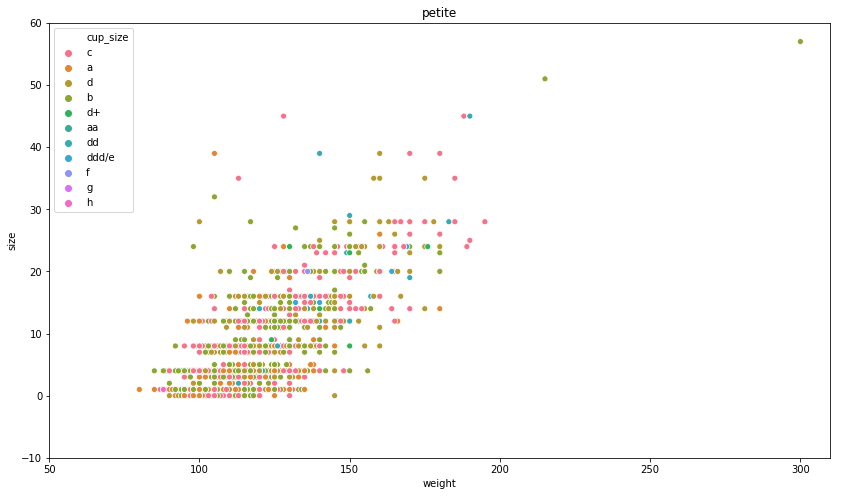

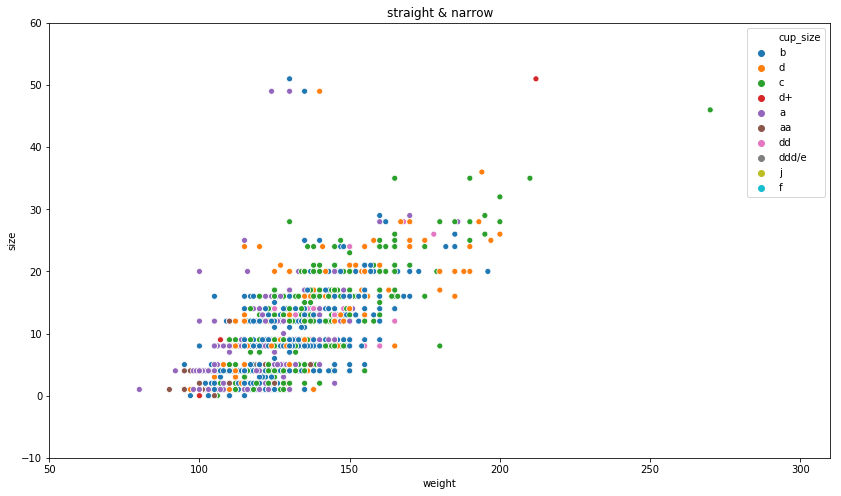

In [34]:
for bodytype in rtr_body_types:
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x='weight', y='size', hue='cup_size', legend='brief', data=rtr_data.loc[rtr_data.body_type==bodytype].groupby('user_id').first())
    plt.title(bodytype)
    plt.xlim(50,310)
    plt.ylim(-10,60)
    plt.show()

In [10]:
rtr_data.loc[(rtr_data.category=='dress')&(rtr_data.body_type=='hourglass')].describe()

,age,height,item_id,rating,size,user_id,weight,band_size,review_text_word_count,review_summary_word_count
count,26615.000000,26587.000000,2.667000e+04,26653.000000,26670.000000,26670.000000,22163.000000,24830.000000,26670.000000,26670.000000
mean,34.001428,65.404897,8.643773e+05,9.027502,14.359580,499532.420097,143.827957,34.499799,58.274841,6.737908
std,7.654184,2.507510,6.107497e+05,1.462330,8.238299,291470.253586,22.025786,1.752423,41.431928,4.902820
min,0.000000,54.000000,1.242040e+05,2.000000,0.000000,35.000000,95.000000,28.000000,1.000000,0.000000
25%,29.000000,64.000000,2.111460e+05,8.000000,8.000000,249089.500000,130.000000,34.000000,28.000000,3.000000
50%,32.000000,65.000000,7.953200e+05,10.000000,14.000000,498591.500000,140.000000,34.000000,50.000000,5.000000
75%,37.000000,67.000000,1.420770e+06,10.000000,20.000000,754443.000000,155.000000,36.000000,78.000000,9.000000
max,117.000000,75.000000,1.995373e+06,10.000000,57.000000,999997.000000,300.000000,44.000000,378.000000,118.000000


In [11]:
rtr_data.loc[(rtr_data.category=='dress')&(rtr_data.body_type=='apple')].describe()

,age,height,item_id,rating,size,user_id,weight,band_size,review_text_word_count,review_summary_word_count
count,2405.000000,2402.000000,2.411000e+03,2411.000000,2411.000000,2411.000000,1987.000000,2241.000000,2411.000000,2411.000000
mean,36.446154,64.898834,8.711704e+05,8.880962,20.803816,512432.129822,155.553598,35.732262,57.405226,6.886354
std,8.583695,2.571138,6.103009e+05,1.548234,10.726092,288708.657578,26.889493,2.005278,42.424280,4.873200
min,18.000000,55.000000,1.242040e+05,2.000000,1.000000,968.000000,102.000000,28.000000,1.000000,1.000000
25%,31.000000,63.000000,2.317500e+05,8.000000,12.000000,269849.000000,135.000000,34.000000,26.000000,3.000000
50%,35.000000,65.000000,8.202440e+05,10.000000,20.000000,504125.000000,150.000000,36.000000,48.000000,5.000000
75%,40.000000,67.000000,1.424883e+06,10.000000,24.000000,777877.000000,170.000000,36.000000,77.000000,9.000000
max,117.000000,74.000000,1.995373e+06,10.000000,57.000000,999743.000000,265.000000,48.000000,373.000000,38.000000


***